In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from difflib import SequenceMatcher
import imageio

from skimage import io # for reading the images
import os # accessing the files 
from skimage.color import * # for rgb2gray
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern # Library for local_binary_pattern
import numpy as np 
import pandas as pd
from skimage.metrics import structural_similarity
from skimage.feature import canny # canny edge detector

2021-12-15 01:30:21.190264: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3) #Decode a JPEG-encoded image to a uint8 tensor.
    return img.numpy()

# normalising the scores using min-max normalization
def normalise(scores):
    
    # getting maximum and minimum values
    max_value = max(scores)
    min_value = min(scores)
    
    # a list to store normalised scores
    norm_scores = []
    for scr in scores:
        try:
            norm_scr = (scr - min_value) / (max_value - min_value) # min-max normalization
            norm_scores.append(norm_scr)
        except ZeroDivisionError:
            norm_scores.append(0)
        
    # adding an index value to each element
    return np.array(norm_scores)

## 4 types of voting function

In [3]:
# object based vote using CNN
def run_detector(detector, img):
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key:value.numpy() for key,value in result.items()} #tensor to numpy
    return result

def object_based_vote(detector, image1, image2):# take two image
    
    # use pre trained model to get result
    results = []
    result = run_detector(detector, image1) 
    results.append(result)
    result = run_detector(detector, image2) 
    results.append(result)
    
    # compare objects detected from two frames
    img1_object = results[0]["detection_class_labels"]
    img2_object = results[1]["detection_class_labels"]
    diff_object = 1-SequenceMatcher(None,img1_object,img2_object).ratio()

    # compare objects' size detected from two frames
    width, height, _ = image1.shape
    
    img1_boxes = results[0]["detection_boxes"]
    img1_boxes_areas = []
    for box in img1_boxes:
        ymin, xmin, ymax, xmax = tuple(box)
        area = (ymax - ymin) * height * (xmax - xmin) * width
        img1_boxes_areas.append(area)
    avg_img1_boxes_areas = np.average(np.array(img1_boxes_areas))
        
    img2_boxes = results[1]["detection_boxes"]
    img2_boxes_areas = []
    for box in img2_boxes:
        ymin, xmin, ymax, xmax = tuple(box)
        area = (ymax - ymin) * height * (xmax - xmin) * width
        img2_boxes_areas.append(area)
    avg_img2_boxes_areas = np.average(np.array(img2_boxes_areas))
    
    diff_size = (avg_img2_boxes_areas - avg_img1_boxes_areas) ** 2
    
    return diff_object, diff_size

In [4]:
# Keypoints based vote
# Check how different two probability distributions (histograms) are using KL divergence
def kullback_leibler_divergence(hist1, hist2): 
    '''
    input: two histograms of same number of bins
    output: kl divergence
    '''
    hist1 = hist1.ravel() # flattening the hist1 array
    hist2 = hist2.ravel() # flattening the hist2 array
    return np.sum(np.where(hist1 != 0, hist1 * np.log(hist1 / hist2), 0)) # calculating KL divergence score

# the function returns a list of differnces between adjacent frames using lbp and KL divergence
def Keypoints_based_vote(image1, image2):
    '''
    input: frames in a video
    output: normalised kl divergence scores between adjacent frames
    '''
    # settings for LBP
    radius = 4 # radius or the size of neighbourhood
    n_points = 4 * radius  # Number of circularly symmetric neighbour set points
    METHOD = 'uniform' # improved rotation invariance with uniform patterns
    
    lbp0 = local_binary_pattern(rgb2gray(image1), n_points, radius, METHOD)
    lbp1 = local_binary_pattern(rgb2gray(image2), n_points, radius, METHOD)

    # number of bins depends on the maximum pixel value in lbp image
    n_bins = int(lbp0.max() + 1)

    ## respective histograms for the two lbp images
    hist0,_ = np.histogram(lbp0, density=True, bins=n_bins, range=(0, n_bins))
    hist1,_ = np.histogram(lbp1, density=True, bins=n_bins, range=(0, n_bins))

    ## computing KL divergence, higher score means highly different frames
    kl_score = kullback_leibler_divergence(hist0 , hist1)

    # adding these scores to a list
    return kl_score

In [5]:
# edge based vote
def edge_based_vote(image1, image2):
    '''
    input: frames from a video
    output: scores based on structural difference between all adjacent  
    '''
    # computing the edge details for frames using canny edge detector
    image1_edge = canny(rgb2gray(image1))
    image2_edge = canny(rgb2gray(image2))
    
    ## computing structural difference between 2 frames
    struct_diff = 1 - structural_similarity(image1_edge, image2_edge)
    return struct_diff

In [6]:
# color based vote
def color_based_vote(image1, image2):
    
    ## convert the frames to grayscale
    gry_frm1 = rgb2gray(image1)
    gry_frm2 = rgb2gray(image2)

    ## finding structural dis-similarity
    struct_difference = 1 - structural_similarity(gry_frm1,gry_frm2)
    return struct_difference

## Function to break video into multiple parts

In [7]:
def get_vote_list(frames_collection, detector):
    object_vote = []
    obj_size_vote = []
    keyponts_vote = []
    edge_vote = []
    color_vote = []
    
    # get votes for differences of each adjcent frame
    for i in range (len(frames_collection) - 1):
        obj, obj_size = object_based_vote(detector, frames_collection[i], frames_collection[i+1])
        object_vote.append(obj)
        obj_size_vote.append(obj_size)
        keyponts_vote.append(Keypoints_based_vote(frames_collection[i], frames_collection[i+1]))
        edge_vote.append(edge_based_vote(frames_collection[i], frames_collection[i+1]))
        color_vote.append(color_based_vote(frames_collection[i], frames_collection[i+1]))
        
    # normalize each vote list
    object_vote = normalise(object_vote)
    obj_size_vote = normalise(obj_size_vote)
    keyponts_vote = normalise(keyponts_vote)
    edge_vote = normalise(edge_vote)
    color_vote = normalise(color_vote)
    
    # calculate total vote
    total_vote = object_vote + obj_size_vote + keyponts_vote + edge_vote + color_vote
    return total_vote

def split_video(frames_collection, detector):
    
    # calculate total vote
    total_vote = get_vote_list(frames_collection, detector)
    
    # get top three index
    top3_idx = total_vote.argsort()[::-1][0:3]
    split_point = top3_idx
    split_point.sort()
    split_point = split_point.tolist()
    split_point.append(len(frames_collection) - 1)
    split_video = []
    current = 0
    for idx in range (len(split_point)):
        temp = []
        for i in range (current, split_point[idx] + 1):
            temp.append(frames_collection[i])
        current = split_point[idx] + 1
        split_video.append(temp)
    
    return split_video

## Function to generate most important frame

In [8]:
def get_important_frames(splited_frames, detector,frames_collection):
    important_frame_collection = []
    for part in splited_frames:
        frame_vote = []
        if len(part) == 1:
            important_frame_collection.append(part[0])
        else:
            for i in range (len(part)):
                frame = part[i]
                temp = part[:]
                temp.pop(i)
                object_vote = []
                obj_size_vote = []
                keyponts_vote = []
                edge_vote = []
                color_vote = []

                for compared_frame in temp:
                    obj, obj_size = object_based_vote(detector, frames_collection[i], frames_collection[i+1])
                    object_vote.append(obj)
                    obj_size_vote.append(obj_size)
                    keyponts_vote.append(Keypoints_based_vote(frame, compared_frame))
                    edge_vote.append(edge_based_vote(frame, compared_frame))
                    color_vote.append(color_based_vote(frame, compared_frame))

                object_vote = normalise(object_vote)
                obj_size_vote = normalise(obj_size_vote)
                keyponts_vote = normalise(keyponts_vote)
                edge_vote = normalise(edge_vote)
                color_vote = normalise(color_vote)
                
                total_vote = object_vote + obj_size_vote + keyponts_vote + edge_vote + color_vote
                frame_vote.append(np.average(total_vote))

            best_frame_idx = np.array(frame_vote).argsort()[0]
            important_frame_collection.append(part[best_frame_idx])
    return important_frame_collection
            

## Function to generate Collage

In [9]:
def img_merge(image_list,alpha): #输入一个list（包含四张frame的np.array）， 以及一个alpha值代表羽化宽度
    
    # get four image
    img_1,img_2,img_3,img_4 = tuple(image_list) 
    height, width, depth = img_1.shape
    # calculate the height and width of overlap places
    height_overlap = int(height * alpha)
    width_overlap = int(width * alpha)
    # calculate the height and width of output image
    height_co = height*2-height_overlap
    width_co = width*2-width_overlap
    
    # fuse the first two image on top
    overlap_area_1 = np.zeros([height,width_overlap,3])
    for col in range(width_overlap):
        for row in range(height):
            rate = (col+1)/width_overlap
            overlap_area_1[row][col] = img_1[row][width-width_overlap+col-1]*(1-rate) + img_2[row][col]*rate
    temp1 = np.hstack((img_1[:,0:width-width_overlap],overlap_area_1))
    temp2 = np.hstack((temp1,img_2[:,width_overlap:]))  
    
    # fuse the other two image at bottom
    overlap_area_2 = np.zeros([height,width_overlap,3])
    for col in range(width_overlap):
        for row in range(height):
            rate = (col+1)/width_overlap
            overlap_area_2[row][col] = img_3[row][width-width_overlap+col-1]*(1-rate) + img_4[row][col]*rate                
    temp3 = np.hstack((img_3[:,0:width-width_overlap],overlap_area_2))
    temp4 = np.hstack((temp3,img_4[:,width_overlap:]))
    
    # fuse the top part and bottom part
    overlap_area_3 = np.zeros([height_overlap,width_co,3])
    for col in range(width_co):
        for row in range(height_overlap):
            rate = (row+1)/height_overlap    
            overlap_area_3[row][col] = temp2[height-height_overlap+row-1][col]*(1-rate) + temp4[row][col]*rate
    temp5 = np.vstack((temp2[0:height-height_overlap,:],overlap_area_3))
    temp6 = np.vstack((temp5,temp4[height_overlap:,:]))
    
    return temp6

## Function to generate GIF

In [10]:
def generate_gif_frames(frames, fps, important_frames):
    '''
    input: list of frames, number of frames per second
    output: list of frames for gif
    '''
    
    number_of_frames = len(frames) # number of frames in the list frames
    frames_gif = [] # a list to store the gif frames
    
    # creating the transition images/frames
    # transition: Adjacent frames in the list are taken, 
    # next, second frames is added to the first frame using the below equation:
    
    # new_frame = (1 - alpha) * first_frame + alpha * second_frame, where the value of alpha increases from 0 - 0.9.
    
    # This creates an effect where the first frame starts fading away and the second frame starts appearing. 
    # At last, only the second frame is visible.
    
    for i in range((number_of_frames)):

        for fr in range(fps):
            # alpha = index of frame in consideration / total number of frame, 
            # e.g. if the 5th frame is computed, and total number of frames is 10, then alpha = 5 / 10
            alpha = fr/fps    # alpha is a balancing coefficient between the first frame and second frame (goes from 0 to 0.9)
            
            if i < 3:
                # computing a new frame from adjacent frames
                transition_img = (important_frames[i]*(1-alpha))/255 + (important_frames[i+1]*alpha)/255   
            else:
                transition_img = (important_frames[i]*(1-alpha))/255 + (important_frames[0]*alpha)/255
                
            # adding the frames to gif frames list
            frames_gif.append(transition_img)
    return frames_gif

## Main function: generateCoolSummary

2021-12-15 01:30:22.940165: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-15 01:30:22.940887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-12-15 01:30:22.965174: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-15 01:30:22.965456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.683GHz coreCount: 28 deviceMemorySize: 10.91GiB deviceMemoryBandwidth: 451.17GiB/s
2021-12-15 01:30:22.965471: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2021-12-15 01:30:22.966657: I tensorflow/stream_executor/platfor

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2021-12-15 01:30:25.931171: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-15 01:30:25.948829: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz
2021-12-15 01:30:36.001953: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2021-12-15 01:30:36.658260: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
/home/adam/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


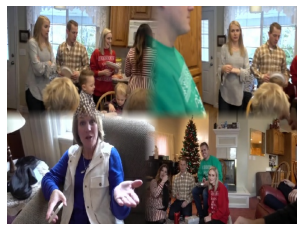

In [11]:
def generateCoolSummary(folder_address = 3):
    # load frames
    frames_collection = []
    for i in range (15):
        full_address = "{}/{}_{}.jpg".format(folder_address,folder_address,i+1) 
        frames_collection.append(load_img(full_address))
    
    # download cnn model
    module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" 
    detector = hub.load(module_handle).signatures['default']
    
    # split video into multiple parts
    splited_frames = split_video(frames_collection, detector)
    
    # generate most important frames for each parts
    important_frames = get_important_frames(splited_frames, detector,frames_collection)
    
    #---------------------------------------------------------
    # generate collage
    collage = img_merge(important_frames, 0.1)
    
    # display collage
    plt.imshow(collage/255)
    plt.axis("off")
    plt.show()
    io.imsave("COLLAGE_OUTPUT.jpg",collage)
    
    #---------------------------------------------------------
    # generate GIF
    gif_frames = generate_gif_frames(important_frames,10,important_frames)
    
    gif_frames_paths = []
    for i, frm in enumerate(gif_frames):
        # saving the gif frames to current directory
        gif_frames_path = './gif_frames/Gif_frames_' + str(i+1) + '.jpg'
        gif_frames_paths.append(gif_frames_path)
        temp = (frm*255).astype(np.uint8)
        io.imsave(gif_frames_path,temp)

    gif_images = []
    for path in gif_frames_paths:
        gif_images.append(imageio.imread(path))
    imageio.mimsave("GIF_OUTPUT.gif",gif_images,fps=2)

if __name__ == "__main__":
    generateCoolSummary(3)